In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import mlflux.gotm
from mlflux.gotm import read2010, predict, gen_epsilon_flux

%load_ext autoreload
%autoreload 3

## Flux prediction by ANN on GOTM file
This file performs similar function to `/script/fluxgen.py` and was used during testing.

### Read in and select time range

In [13]:
# Path
path = '/home/jw8736/code-5.2.1/cases/ows_papa/'
df = read2010(path, datetimeformat='%Y-%m-%d %H:%M:%S')

# Interpolate to hourly
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
ds_uniform = ds.resample(datetime='H').interpolate('linear') # Interpolation non-uniform to hourly

# Select a range of dates
sd = '2012-01-01'; ed = '2012-12-30'
# sd = '2012-05-21'; ed = '2012-08-20'
# sd = '2012-08-21'; ed = '2013-01-10'
ds = ds_uniform.sel(datetime=slice(sd,ed))

ds = ds.resample(datetime='3H').mean() # Coarsening to 3-hourly

In [3]:
import torch
import pickle

def predict (ds):
    model_dir = '/home/jw8736/mlflux/saved_model/one_output_anns/'  
    # Assemble input X
    input_keys = ['U','sst','t','rh']
    X = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))

    # Three fluxes if they are separate ANNs
    # TODO: make it compatible with ANNs of four outputs
    model_names = ['Flux41_momentum_3layers_weighted_rand10.p', 'Flux41_sensible_3layers_weighted_rand10.p', 'Flux41_latent_3layers_weighted_rand8.p']
    print ('Predicting fluxes and stds based on ANNs in directory ' + model_dir + '...')

    for i, model_name in enumerate(model_names):
        filename = model_dir + model_name
        with open(filename, "rb") as input_file:
            model = pickle.load(input_file)
            mean = model.pred_mean(X).detach().numpy().squeeze()
            var = model.pred_var(X).detach().numpy().squeeze()
            if i == 0: # Momentum
                ds['taux_ann'] = mean*ds.cos
                ds['tauy_ann'] = mean*ds.sin
                ds['taux_ann_var'] = abs(var*ds.cos) # is this valid
                ds['tauy_ann_var'] = abs(var*ds.sin) # is this valid
            elif i == 1: # Sensible heat
                ds['qh_ann'] = mean*ds.Q/ds.Q
                ds['qh_ann_var'] = var*ds.Q/ds.Q 
            elif i == 2: # Latent heat 
                ds['ql_ann'] = mean*ds.Q/ds.Q
                ds['ql_ann_var'] = var*ds.Q/ds.Q 

    ds['Q_ann'] = ds.qh_ann + ds.ql_ann + ds.lwr
    print ('Finished!')
    return ds

### Apply ANN to compute fluxes and generate stochastic ensemble
There are still room for improvements for ANN

In [14]:
from mlflux.predictor import Fluxdiff # This is needed in the main. We will optimize later
ds = predict(ds)

Predicting fluxes and stds based on ANNs in directory /home/jw8736/mlflux/saved_model/one_output_anns/...
Finished!


In [15]:
T=60
dt=3
ENSEM=20
Q_eps_ensem = gen_epsilon_flux (ds, FLUX='heat', T=T, dt=dt, ENSEM=ENSEM)

Generating an ensemble of heat flux. Size=20.
Finished! eps_ensem array shape: (20, 2920)


(15614.0, 15645.0)

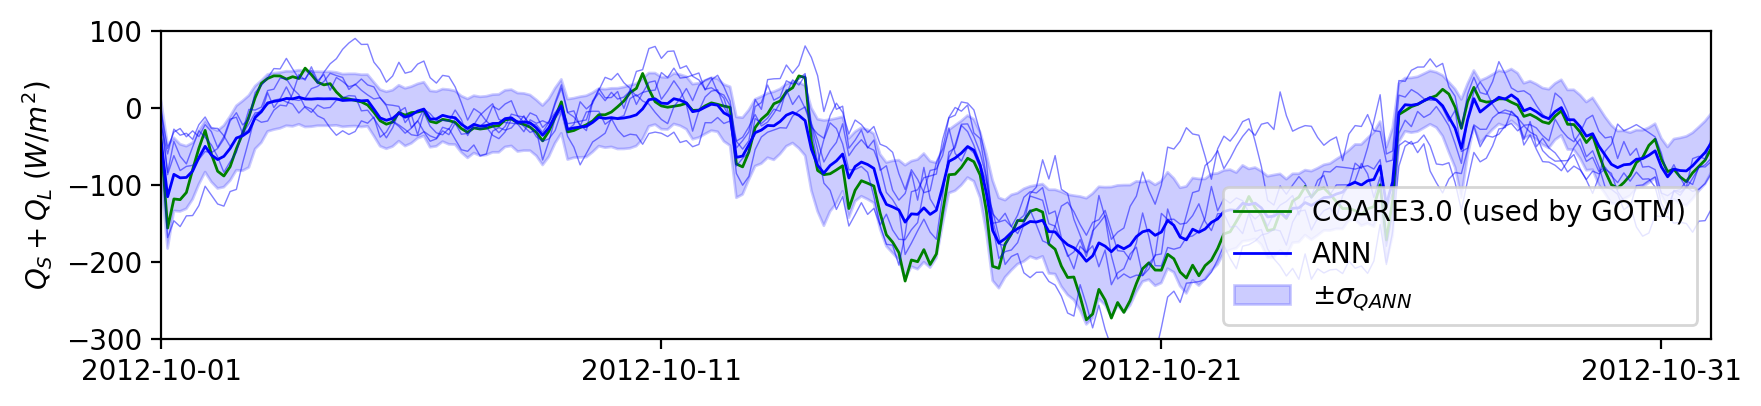

In [25]:
''' Heat flux '''
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

# Q-LWR from the flux data provided from GOTM
# computed from COARE3.0 (have tested this)
plt.plot(ds.datetime, ds.Q - ds.lwr, label='COARE3.0 (used by GOTM)', c='g', lw=1) 

# computed from ANNs
interval = (ds.qh_ann_var + ds.ql_ann_var)**0.5
mean = ds.Q_ann - ds.lwr
plt.plot(ds.datetime, mean, label='ANN', color='blue', lw=1)
plt.fill_between(ds.datetime, mean-interval, mean+interval, 
                 color='blue', alpha=0.2, label='$\pm \sigma_{QANN}$')

for i in range(0,ENSEM,4):
    plt.plot(ds.datetime, mean+Q_eps_ensem[i], lw=0.5, alpha=0.5, c='b')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend(loc='lower right')
plt.ylim([-300, 100]); plt.ylabel('$Q_S+Q_L \; (W/m^2)$')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xlim([pd.Timestamp('2012-10-01'),pd.Timestamp('2012-11-01')])

Text(0, 0.5, '$Q_h+Q_l \\; (W/m^2)$')

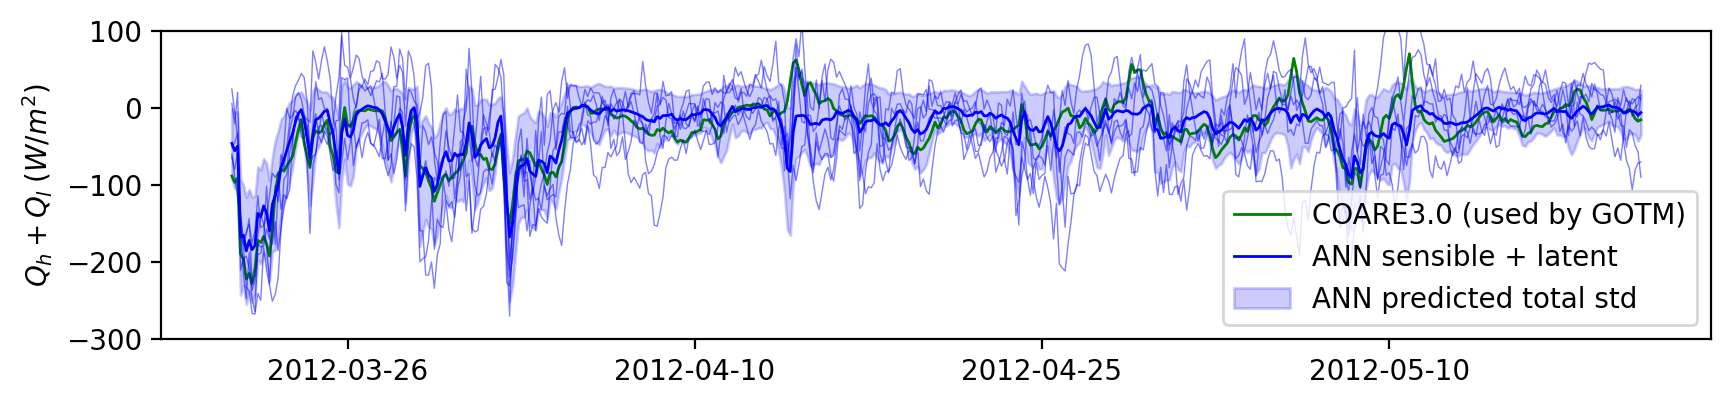

In [37]:
''' Heat flux '''
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

# Q-LWR from the flux data provided from GOTM
# computed from COARE3.0 (have tested this)
plt.plot(ds.datetime, ds.Q - ds.lwr, label='COARE3.0 (used by GOTM)', c='g', lw=1) 

# computed from ANNs
interval = (ds.qh_ann_sigma + ds.ql_ann_sigma)**0.5
mean = ds.Q_ann - ds.lwr
plt.plot(ds.datetime, mean, label='ANN sensible + latent', color='blue', lw=1)
plt.fill_between(ds.datetime, mean-interval, mean+interval, 
                 color='blue', alpha=0.2, label='ANN predicted total std')

for i in range(0,ENSEM,20):
    plt.plot(ds.datetime, mean+Q_eps_ensem[i], lw=0.5, alpha=0.5, c='b')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.ylim([-300, 100]); plt.ylabel('$Q_h+Q_l \; (W/m^2)$')

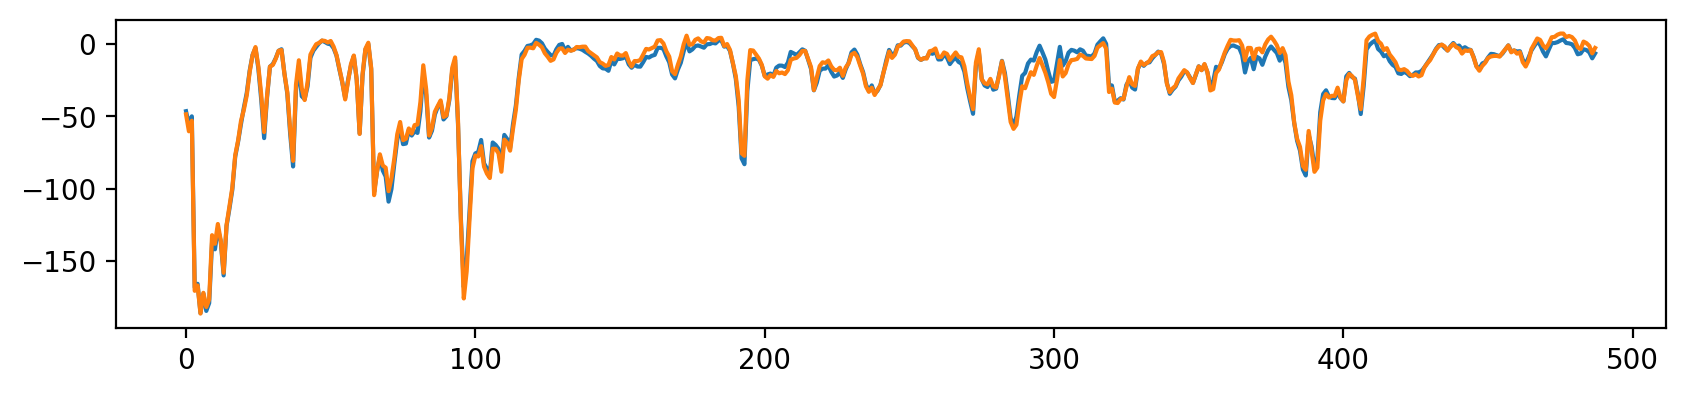

In [27]:
''' Difference between ensemble mean and ANN mean '''
Q_eps_mean = Q_eps_ensem.mean(axis=0)

fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()
plt.plot(mean)
plt.plot(mean+Q_eps_mean)

In [22]:
T=20
dt=3
ENSEM=100
taux_eps_ensem = gen_epsilon_flux (ds, FLUX='taux', T=T, dt=dt, ENSEM=ENSEM)

Generating an ensemble of taux flux. Size=100.
Finished! eps_ensem array shape: (100, 488)


Text(0, 0.5, '$\\tau_x \\; (m^2/s^2)$')

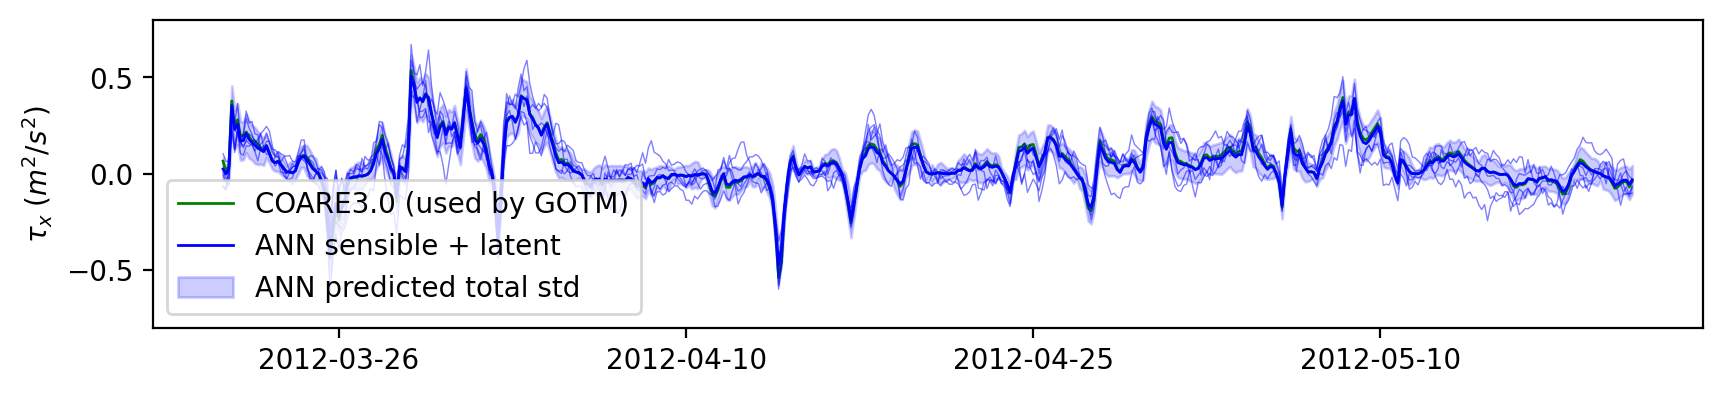

In [24]:
''' Momentum flux
    CHECK: the uncertainty seems a bit small. '''
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

# Q-LWR from the flux data provided from GOTM
# computed from COARE3.0 (have tested this)
plt.plot(ds.datetime, ds.taux, label='COARE3.0 (used by GOTM)', c='g', lw=1) 

# computed from ANNs
interval = ds.taux_ann_var**0.5
mean = ds.taux_ann
plt.plot(ds.datetime, mean, label='ANN sensible + latent', color='blue', lw=1)
plt.fill_between(ds.datetime, mean-interval, mean+interval, 
                 color='blue', alpha=0.2, label='ANN predicted total std')

for i in range(0,ENSEM,20):
    plt.plot(ds.datetime, mean+taux_eps_ensem[i], lw=0.5, alpha=0.5, c='b')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.ylim([-0.8,0.8]) 
plt.ylabel(r'$\tau_x \; (m^2/s^2)$')

### Data of 1960s
Some older codes.

In [ ]:
''' Older code '''
def read_fluxes (heat_data_file='heatflux.dat', momentum_data_file='momentumflux.dat',
                 datetimeformat='%Y/%m/%d %H:%M:%S'):

    # Use read_csv to read the file
    df1 = pd.read_csv(heat_data_file, sep='\s+', header=None, names=['date', 'time', 'Q'])
    # Combine the 'date' and 'time' columns into a single 'datetime' column
    df1['datetime'] = df1['date'] + ' ' + df1['time']
    # Convert 'datetime' column to datetime format
    df1['datetime'] = pd.to_datetime(df1['datetime'], format=datetimeformat)
    # Drop the separate 'date' and 'time' columns if they are no longer needed
    df1.drop(columns=['date', 'time'], inplace=True)
    # Combine the date and time columns if necessary
    # Ensure 'datetime' column is in the correct format
    df1['datetime'] = pd.to_datetime(df1['datetime'], format=datetimeformat)
    
    df2 = pd.read_csv(momentum_data_file, sep='\s+', header=None, names=['date', 'time', 'taux', 'tauy'])
    df2['datetime'] = df2['date'] + ' ' + df2['time']
    df2['datetime'] = pd.to_datetime(df2['datetime'], format=datetimeformat)
    df2.drop(columns=['date', 'time'], inplace=True)
    df2['datetime'] = pd.to_datetime(df2['datetime'], format=datetimeformat)

    df = pd.merge(df1, df2, on='datetime')
    df = df[['datetime','Q','taux','tauy']]
    
    xrdf = xr.Dataset(
    {'taux': (['t'], df.taux),
    'tauy': (['t'], df.tauy),
    'Q': (['t'], df.Q)},
    coords={
        "t": df.datetime,
    },)
    
    return xrdf

    
fig = plt.figure(figsize=[8,2],dpi=200)
ax = plt.gca()

df = read_fluxes(heat_data_file='heatflux.dat', momentum_data_file='momentumflux.dat',
                 datetimeformat='%Y/%m/%d %H:%M:%S')

Q_hat = df.Q.coarsen({'t':8}, boundary='trim').mean()
ax.plot(df.t[:1000], df.Q[:1000], alpha=0.5, label='3 hourly')
ax.plot(df.t[:1000:8], df.Q[:1000:8], c='C0', alpha=1, label='Sampling')
ax.plot(df.t[:1000:8], Q_hat[:125], '--', c='C0', alpha=1, label='Filtering')

ax.set_ylabel(r'Heat flux ($W/m^2$)')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend()
plt.show()

In [ ]:
time_ = df1['datetime'].dt.strftime('%Y/%m/%d %H:%M:%S')

# Merge DataFrames on their index (the "time" coordinate in this case)
Q_hat_pd = pd.merge(Q_hat.t.to_dataframe(), Q_hat.to_dataframe(), left_index=True, right_index=True)
Q_hat_pd.to_csv("heatflux_filter1day.txt", sep=' ', header=False, index=False)